# Train a PyTorch Classifier
In the udacity course we were introduced to a plagiarism dataset which we will use here to train our model. Rather than go through the feature engineering steps we'll simply take the training and testing data from that notebook as our starting point.

# Initialise

In [1]:
import sys
sys.path.insert(1, '../') 

# where to save torch model output
MODEL_DIR = '../model'

## Load Data

In [3]:
import pickle
plagiarism_data = pickle.load(open('plagiarism_data.p', 'rb'))
plagiarism_data.keys()

dict_keys(['train_x', 'train_y', 'test_x', 'test_y'])

In [4]:
# unpack data
train_x, train_y, test_x, test_y = plagiarism_data.values()

In [6]:
# check
print(f"train_x has shape {train_x.shape}")
print(f"train_y has shape {train_y.shape}")
print(f"test_x has shape {test_x.shape}")
print(f"test_y has shape {test_y.shape}")

train_x has shape (70, 2)
train_y has shape (70,)
test_x has shape (25, 2)
test_y has shape (25,)


# Visualise Training Data
Visualising our training data may give an indication as to the relationship between the inputs and the targets, and guide us to the level of non-linearity present in the data. It will inform our choice of algorithm

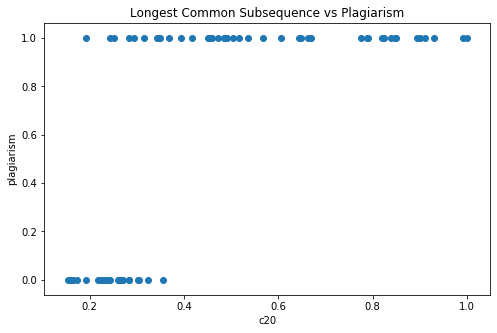

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize = (8, 5))
plt.scatter(train_x[:,1], train_y)
plt.title('Longest Common Subsequence vs Plagiarism')
plt.xlabel('c20')
plt.ylabel('plagiarism')
plt.show()

Everything above longest common subsequence 0.38 appears to be plagiarised

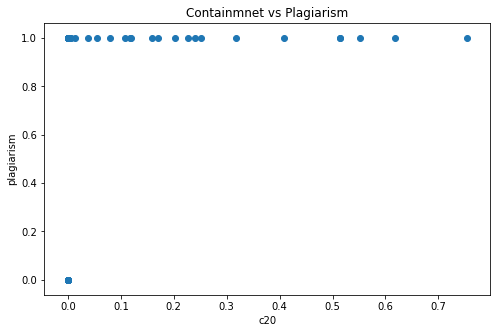

In [8]:
plt.figure(figsize = (8, 5))
plt.scatter(train_x[:,0], train_y)
plt.title('Containmnet vs Plagiarism')
plt.xlabel('c20')
plt.ylabel('plagiarism')
plt.show()

Containmnet looks to be a much better predictor of plagiarism, with everything above 0 indicating plagiarism

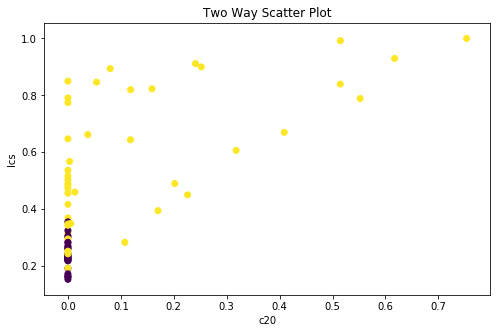

In [9]:
# points are coloured by class, train_y
import matplotlib.pyplot as plt

plt.figure(figsize = (8, 5))
plt.scatter(train_x[:,0], train_x[:,1], c = train_y)
plt.title('Two Way Scatter Plot')
plt.xlabel('c20')
plt.ylabel('lcs')
plt.show()

Using both these features in a model should give us a good decision boundary for classifying plagiarism

# Training the Model

We are going to train a neural network to classify the students answers into plagiarised vs non-plagiarised. As part of the udacity course they provided some boiler plate code to train the network using amazon sagemaker. 

In our situation we are not looking to deploy the model as an API and therefore using sagemaker is overkill, and too timeconsuming. Instead we'll write a basic pytorch classifier ourselves, and score the medium data using the local machine

In [10]:
import torch.utils.data

# Turn the numpy arrays into tensors
train_x = torch.from_numpy(train_x).float()
train_y = torch.from_numpy(train_y).float().squeeze()

# build the torch dataset
train_ds = torch.utils.data.TensorDataset(train_x, train_y)

# build the data loaders
train_dl = torch.utils.data.DataLoader(train_ds, batch_size = 10)

In [11]:
def train(model, train_loader, epochs, optimizer, criterion, device):
    
    for epoch in range(1, epochs + 1):
        # monitor training loss
        train_loss_total = 0
        
        ######################
        # train the model    #
        ######################
        model.train() # prep model for training
        
        for data, target in train_loader:
            target = target.contiguous().view(-1, 1)
            
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad() # zero accumulated gradients
            output = model(data) # make a forward pass
            loss = criterion(output, target)
            loss.backward() # make a backward pass
            optimizer.step()
            
            train_loss_total += loss.item()
            
        # calculate average loss over an epoch
        train_loss = train_loss_total / len(train_loader)
        
        # print loss statistics
        print(f"Epoch: {epoch}, train_loss: {train_loss}")

In [13]:
from src.utils.model import BinaryClassifier

In [14]:
!pygmentize '../src/utils/model.py'

# torch imports
import torch.nn.functional as F
import torch.nn as nn

class BinaryClassifier(nn.Module):
    """
    Define a neural network that performs binary classification.
    The network should accept your number of features as input, and produce 
    a single sigmoid value, that can be rounded to a label: 0 or 1, as output.
    
    Notes on training:
    To train a binary classifier in PyTorch, use BCELoss.
    BCELoss is binary cross entropy loss, documentation: https://pytorch.org/docs/stable/nn.html#torch.nn.BCELoss
    """

    ## TODO: Define the init function, the input params are required (for loading code in train.py to work)
    def __init__(self, input_features, hidden_dim, output_dim):
        """
        Initialize the model by setting up linear layers.
        Use the input parameters to help define the layers of your model.
        :param input_features: the number of input features in your training/test data
        :param hidden_dim: helps define the number of

In [15]:
import torch.optim as optim

input_features = 2
hidden_dim = 7
output_dim = 1
learning_rate = 0.001
epochs = 300

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BinaryClassifier(input_features, hidden_dim, output_dim)
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
loss_fn = torch.nn.BCELoss()

train(model, train_dl, epochs, optimizer, loss_fn, device)

Epoch: 1, train_loss: 0.7472945536885943
Epoch: 2, train_loss: 0.759077787399292
Epoch: 3, train_loss: 0.7374642406191144
Epoch: 4, train_loss: 0.7276319776262555
Epoch: 5, train_loss: 0.7322274020739964
Epoch: 6, train_loss: 0.7273526872907367
Epoch: 7, train_loss: 0.7023512295314244
Epoch: 8, train_loss: 0.6859994190079826
Epoch: 9, train_loss: 0.7140462653977531
Epoch: 10, train_loss: 0.6955571259771075
Epoch: 11, train_loss: 0.7011607544762748
Epoch: 12, train_loss: 0.7066753932407924
Epoch: 13, train_loss: 0.6893866998808724
Epoch: 14, train_loss: 0.66790223973138
Epoch: 15, train_loss: 0.6755419969558716
Epoch: 16, train_loss: 0.6711660964148385
Epoch: 17, train_loss: 0.6675820180347988
Epoch: 18, train_loss: 0.6998547230448041
Epoch: 19, train_loss: 0.6727805648531232
Epoch: 20, train_loss: 0.6596989035606384
Epoch: 21, train_loss: 0.6593705756323678
Epoch: 22, train_loss: 0.6718628065926688
Epoch: 23, train_loss: 0.6655730264527457
Epoch: 24, train_loss: 0.6628822343690055
Epoc

Epoch: 205, train_loss: 0.4477873742580414
Epoch: 206, train_loss: 0.4471562164170401
Epoch: 207, train_loss: 0.4399718599660056
Epoch: 208, train_loss: 0.41448672328676495
Epoch: 209, train_loss: 0.4530919236796243
Epoch: 210, train_loss: 0.43080684542655945
Epoch: 211, train_loss: 0.4606122672557831
Epoch: 212, train_loss: 0.4494378737040928
Epoch: 213, train_loss: 0.4486898737294333
Epoch: 214, train_loss: 0.44632130009787424
Epoch: 215, train_loss: 0.43203974621636526
Epoch: 216, train_loss: 0.43535326208387104
Epoch: 217, train_loss: 0.4177892165524619
Epoch: 218, train_loss: 0.44405763915606905
Epoch: 219, train_loss: 0.459799872977393
Epoch: 220, train_loss: 0.44242118086133686
Epoch: 221, train_loss: 0.4360283485480717
Epoch: 222, train_loss: 0.43971277134759085
Epoch: 223, train_loss: 0.4553458477769579
Epoch: 224, train_loss: 0.44486806648118155
Epoch: 225, train_loss: 0.4124944337776729
Epoch: 226, train_loss: 0.40906105296952383
Epoch: 227, train_loss: 0.41843925203595844
E

# Predict Test Data

In [16]:
# Provided predict function
def predict_fn(input_data, model):
    print('Predicting class probabilities for the input data...')

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Process input_data so that it is ready to be sent to our model.
    data = torch.from_numpy(input_data.astype('float32'))
    data = data.to(device)

    # Put the model into evaluation mode
    model.eval()

    # Predicted scores
    probabilities = model(data).cpu().detach().numpy()

    return probabilities

In [17]:
probabilities = predict_fn(test_x, model)

Predicting class probabilities for the input data...


In [18]:
labels = probabilities.round()

In [19]:
labels.shape

(25, 1)

## Evaluate Model

In [20]:
# returns a variety of model metrics
import pandas as pd
import numpy as np

def evaluate(test_preds, test_labels, verbose=True):
    """
    Evaluate a model on a test set given the prediction endpoint.  
    Return binary classification metrics.
    :param predictor: A prediction endpoint
    :param test_features: Test features
    :param test_labels: Class labels for test data
    :param verbose: If True, prints a table of all performance metrics
    :return: A dictionary of performance metrics.
    """
    test_preds = np.squeeze(test_preds)
    
    # calculate true positives, false positives, true negatives, false negatives
    tp = np.logical_and(test_labels, test_preds).sum()
    fp = np.logical_and(1-test_labels, test_preds).sum()
    tn = np.logical_and(1-test_labels, 1-test_preds).sum()
    fn = np.logical_and(test_labels, 1-test_preds).sum()
    
    # calculate binary classification metrics
    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    accuracy = (tp + tn) / (tp + fp + tn + fn)
    
    # print metrics
    if verbose:
        print(pd.crosstab(test_labels, test_preds, rownames=['actuals'], colnames=['predictions']))
        print("\n{:<11} {:.3f}".format('Recall:', recall))
        print("{:<11} {:.3f}".format('Precision:', precision))
        print("{:<11} {:.3f}".format('Accuracy:', accuracy))
        print()
        
    return {'TP': tp, 'FP': fp, 'FN': fn, 'TN': tn, 
            'Precision': precision, 'Recall': recall, 'Accuracy': accuracy}

In [21]:
metrics = evaluate(labels, test_y)

predictions  0.0  1.0
actuals              
0              9    1
1              0   15

Recall:     1.000
Precision:  0.938
Accuracy:   0.960



# Save Model

In [22]:
## TODO: complete in the model_info by adding three argument names, the first is given
# Keep the keys of this dictionary as they are 
import os

model_info_path = os.path.join(MODEL_DIR, 'model_info.pth')
with open(model_info_path, 'wb') as f:
    model_info = {
        'input_features': input_features,
        'hidden_dim': hidden_dim,
        'output_dim': output_dim,
    }
    torch.save(model_info, f)
  
# Save the model parameters
model_path = os.path.join(MODEL_DIR, 'model.pth')
with open(model_path, 'wb') as f:
    torch.save(model.cpu().state_dict(), f)